In [1]:
# 16/06/2020
# TASI.AI
# Raphael Mourad

# ARIMA + Exogenous variables = ARIMAX
# ARIMAX is an ARIMA model but in which you can include additional features 
# such as option features to better predict the price.

# https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html

###### IMPORT LIBRARIES AND SET UP PARAMETERS

# Import libraries
import os
import pandas as pd
import numpy as np
import sklearn.metrics as mt
import random
import datetime
from pandas_datareader import DataReader
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima_model import ARIMA
from pmdarima import auto_arima
from scipy.stats import norm

/home/mourad/.local/lib/python3.6/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
# Set up directory
dir="/media/mourad/diskSave/MCF_Toulouse/recherche/ConsulProj/RamCiri"
os.chdir(dir)
print(os.getcwd())

/media/mourad/diskSave/MCF_Toulouse/recherche/ConsulProj/RamCiri


In [3]:
# Parameters
symbol="AMZN" # Set up the symbol you want
kdays=30 # Number of days for forecasting
kdaysExpi=120 # Number of days until expiration date

In [4]:
# Create folder for symbol
symbolFolder="results/ARIMA_optionstats_features/"+symbol
if(os.path.isdir(symbolFolder)==False):
    os.mkdir(symbolFolder, mode=0o777)

In [5]:
###### LOAD AND PREPROCESS DATA

### STOCK PRICE
# Import price
path="data/stockquotes/samples_L3_stockquotes_sample.csv.gz"
data_stockquotes = pd.read_csv(path, compression='gzip', header=0, sep=',', quotechar='"', error_bad_lines=False)
data_stockquotes["quotedate"] = pd.to_datetime(data_stockquotes["quotedate"])
#print(data_stockquotes)
print(np.unique(data_stockquotes["symbol"]))

# Choose the stock
data_stockquotes_sel=data_stockquotes[data_stockquotes["symbol"]==symbol]
data_stockquotes_sel=data_stockquotes_sel.sort_values('quotedate')
data_stockquotes_sel=data_stockquotes_sel[["symbol","quotedate","close"]]
#data_stockquotes_sel=data_stockquotes_sel.set_index('quotedate')
print(data_stockquotes_sel)

# Check the absence of missing data 
NAcount=data_stockquotes.isnull().sum().sum()
print("Missing data=",NAcount)

['AAPL' 'AMZN' 'AXP' 'BA' 'CAT' 'DIS' 'GOOG' 'GS' 'HD' 'IBM' 'JNJ' 'JPM'
 'KO' 'MCD' 'MRK' 'MSFT' 'NFLX' 'NKE' 'PFE' 'PG' 'XOM']
      symbol  quotedate        close
22852   AMZN 2015-05-01   422.869995
21875   AMZN 2015-05-04   423.040009
22160   AMZN 2015-05-05   421.190002
21851   AMZN 2015-05-06   419.100006
21772   AMZN 2015-05-07   426.880005
...      ...        ...          ...
22225   AMZN 2020-05-22  2436.880000
22926   AMZN 2020-05-26  2421.860000
22226   AMZN 2020-05-27  2410.390000
21874   AMZN 2020-05-28  2401.100000
22795   AMZN 2020-05-29  2442.370000

[1278 rows x 3 columns]
Missing data= 0


In [6]:
### STOCK OPTION STATISTICS
# Import optionstats
pathOptionStats="data/optionstats/samples_L3_optionstats_sample.csv.gz"
data_optionStats = pd.read_csv(pathOptionStats, compression='gzip', header=0, sep=',', quotechar='"', error_bad_lines=False)
data_optionStats["quotedate"] = pd.to_datetime(data_optionStats["quotedate"])
data_optionStats = data_optionStats.drop(columns=["iv30put","iv30mean","iv60put","iv60mean","iv90put","iv90mean",
                                                 "iv120put","iv120mean","iv150put","iv150mean","iv180put","iv180mean",
                                                 "iv360put","iv360mean"])
print(data_optionStats.columns.values)

# Choose the stock
data_optionStats_sel=data_optionStats[data_optionStats["symbol"]==symbol]
data_optionStats_sel=data_optionStats_sel.sort_values(["quotedate"])
#data_optionStats_sel=data_optionStats_sel.set_index('quotedate')
data_optionStats_sel=pd.DataFrame.drop_duplicates(data_optionStats_sel)
data_optionStats_sel=data_optionStats_sel.drop(columns=["symbol"])
print(data_optionStats_sel[["iv30call","iv60call"]])
#print(data_optionStats_sel)

['symbol' 'quotedate' 'iv30call' 'iv60call' 'iv90call' 'iv120call'
 'iv150call' 'iv180call' 'iv360call' 'callvol' 'putvol' 'totalvol'
 'calloi' 'putoi' 'totaloi']
       iv30call  iv60call
25817    0.2506    0.2436
5836     0.2459    0.2407
8518     0.2545    0.2443
19166    0.2435    0.2409
20905    0.2483    0.2421
...         ...       ...
8079     0.2794    0.2945
6690     0.2847    0.2958
40835    0.2805    0.2959
1895     0.2850    0.2986
40114    0.2376    0.2774

[1114 rows x 2 columns]


In [7]:
### STOCK OPTION FEATURES
# Import option_features
pathOptionFeats="data/options_features/samples_L3_options_features_"+symbol+"_"+str(kdaysExpi)+"daysExpi.csv.gz"
data_optionFeats = pd.read_csv(pathOptionFeats, compression='gzip', header=0, sep=',', quotechar='"', error_bad_lines=False)
print(data_optionFeats)
data_optionFeats["DataDate"] = pd.to_datetime(data_optionFeats["DataDate"])

        DataDate    PCR       SM      SWM      WMEP  MROI    WMD    WMG  \
0     2015-05-01  0.713   14.325   25.244   436.484   3.0  0.145  0.008   
1     2015-05-04  1.190   13.550   31.753   412.027   3.0 -0.011  0.008   
2     2015-05-05  0.904   13.948   30.918   431.280   6.5  0.034  0.008   
3     2015-05-06  0.893   13.575   25.729   429.648   8.0  0.071  0.008   
4     2015-05-07  0.579   15.005   29.659   442.782   8.0  0.150  0.008   
...          ...    ...      ...      ...       ...   ...    ...    ...   
1270  2020-05-22  0.553  132.007  209.746  2558.732  12.0  0.118  0.001   
1271  2020-05-26  0.626  126.487  158.550  2492.258  13.0  0.152  0.001   
1272  2020-05-27  1.094  125.685  250.602  2348.693  13.0 -0.069  0.001   
1273  2020-05-28  0.444  125.450  146.825  2420.532  18.0  0.367  0.001   
1274  2020-05-29  0.900  122.975  181.740  2442.528  12.0  0.003  0.001   

          WMT      WMV  
0     -45.243   56.536  
1     -42.813   46.612  
2     -42.931   48.290  

In [8]:
### MERGE PRICE WITH OPTION STATS AND OPTION FEATS

# Merge price with option stats
priceOptionStats=data_stockquotes_sel.merge(data_optionStats_sel, left_on='quotedate', right_on='quotedate')

# Merge with option feats
priceOptionStatsFeats=priceOptionStats.merge(data_optionFeats, left_on='quotedate', right_on='DataDate')

# Format table
priceOptionStatsFeats=priceOptionStatsFeats.drop(columns=["symbol","DataDate"])
priceOptionStatsFeats=priceOptionStatsFeats.set_index('quotedate')
#print(priceOptionStats[["close","iv30call","iv30put"]])
print(priceOptionStatsFeats)

                  close  iv30call  iv60call  iv90call  iv120call  iv150call  \
quotedate                                                                     
2015-05-01   422.869995    0.2506    0.2436    0.2435     0.2578     0.2720   
2015-05-04   423.040009    0.2459    0.2407    0.2442     0.2580     0.2718   
2015-05-05   421.190002    0.2545    0.2443    0.2465     0.2609     0.2753   
2015-05-06   419.100006    0.2435    0.2409    0.2491     0.2623     0.2756   
2015-05-07   426.880005    0.2483    0.2421    0.2455     0.2600     0.2746   
...                 ...       ...       ...       ...        ...        ...   
2020-05-22  2436.880000    0.2794    0.2945    0.3321     0.3250     0.3254   
2020-05-26  2421.860000    0.2847    0.2958    0.3297     0.3236     0.3249   
2020-05-27  2410.390000    0.2805    0.2959    0.3280     0.3221     0.3251   
2020-05-28  2401.100000    0.2850    0.2986    0.3275     0.3209     0.3246   
2020-05-29  2442.370000    0.2376    0.2774    0.312

In [9]:
###### BUILD AND AUTOSELECT ARIMA MODEL

# Split train/test data
priceOptionStatsTrain = priceOptionStatsFeats[0:(len(priceOptionStatsFeats)-kdays)]
priceOptionStatsTest = priceOptionStatsFeats[(len(priceOptionStatsFeats)-kdays):len(priceOptionStatsFeats)]

priceCloseTrain=priceOptionStatsTrain["close"]
priceCloseTest=priceOptionStatsTest["close"]

exogenousTrain=priceOptionStatsTrain.drop(columns="close")
exogenousTest=priceOptionStatsTest.drop(columns="close")
#print(priceOptionStatsTrain)
#print(priceOptionStatsTest[0:5])

In [30]:
# Build ARIMA model and finding automatically the best ARIMA model (function called auto_arima)
autoARIMA = auto_arima(priceCloseTrain, seasonal=False, trace=True,
                error_action='ignore', suppress_warnings=True, stepwise=True)
ARIMAbestparams=autoARIMA.order
print(ARIMAbestparams)
file_autoARIMA = open(symbolFolder+"/autoARIMA_"+symbol+".txt", "a")
file_autoARIMA.write(str(autoARIMA.summary()))
file_autoARIMA.close()

Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=10334.120, BIC=10364.023, Time=0.535 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=10338.127, BIC=10348.095, Time=0.019 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=10334.796, BIC=10349.748, Time=0.038 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=10335.096, BIC=10350.047, Time=0.128 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=10340.440, BIC=10345.424, Time=0.014 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=10333.456, BIC=10358.375, Time=0.449 seconds
Fit ARIMA(0,1,2)x(0,0,0,0) [intercept=True]; AIC=10335.710, BIC=10355.645, Time=0.167 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=10336.601, BIC=10356.536, Time=0.355 seconds
Fit ARIMA(1,1,3)x(0,0,0,0) [intercept=True]; AIC=10333.774, BIC=10363.676, Time=0.838 seconds
Fit ARIMA(0,1,3)x(0,0,0,0) [intercept=True]; AIC=10332.609, BIC=10357.528, Time=0.202 seconds
Fit ARIMA(0,1,4)

In [32]:
# Ranking of exogenous features one by one using AIC
# The higher the loss the better the feature
print("No exo: \tAIC="+str(round(autoARIMA.aic())))

exogenousVars=exogenousTrain.columns.values
AICVars=list()
for k in range(0, len(exogenousVars)):
    vark=exogenousVars[k]
    ARIMAi=auto_arima(priceCloseTrain, exogenous=pd.DataFrame(exogenousTrain[vark]), 
            seasonal=False, trace=False, error_action='ignore', suppress_warnings=True, stepwise=True,
            start_p=ARIMAbestparams[0], d=ARIMAbestparams[1], start_q=ARIMAbestparams[2], 
            max_p=ARIMAbestparams[0], max_d=ARIMAbestparams[1], max_q=ARIMAbestparams[2])
    AICVars.append(ARIMAi.aic())
    print(vark+": \tAIC="+str(round(ARIMAi.aic()))+"\tdiffAIC=",str(round(autoARIMA.aic()-ARIMAi.aic())))

# Save results
matAIC=pd.DataFrame()
matAIC["ExoVar"]=exogenousVars
matAIC["AIC"]=AICVars
matAIC["DiffAIC"]=autoARIMA.aic()-AICVars
matAIC["PercentGainAIC"]=(autoARIMA.aic()-AICVars)/autoARIMA.aic()
pathMatAIC=symbolFolder+"/matrix_ARIMAX_AIC_exogenousVars_"+symbol+".csv"
matAIC.to_csv(pathMatAIC, index=False, sep=',', quotechar='"')

No exo: 	AIC=10333
iv30call: 	AIC=10269	diffAIC= 64
iv60call: 	AIC=10259	diffAIC= 73
iv90call: 	AIC=10274	diffAIC= 58
iv120call: 	AIC=10287	diffAIC= 46
iv150call: 	AIC=10297	diffAIC= 35
iv180call: 	AIC=10312	diffAIC= 20
iv360call: 	AIC=10327	diffAIC= 5
callvol: 	AIC=10327	diffAIC= 5
putvol: 	AIC=10335	diffAIC= -2
totalvol: 	AIC=10332	diffAIC= 1
calloi: 	AIC=10335	diffAIC= -2
putoi: 	AIC=10335	diffAIC= -2
totaloi: 	AIC=10335	diffAIC= -2
PCR: 	AIC=10332	diffAIC= 1
SM: 	AIC=10331	diffAIC= 2
SWM: 	AIC=10310	diffAIC= 22
WMEP: 	AIC=9832	diffAIC= 500
MROI: 	AIC=10335	diffAIC= -2
WMD: 	AIC=10318	diffAIC= 14
WMG: 	AIC=10333	diffAIC= 0
WMT: 	AIC=10314	diffAIC= 18
WMV: 	AIC=10294	diffAIC= 39


In [48]:
###### Assess combination of exogenous variables to find the best combination

# List of best exogenous variable candidates
zippedVarSel=zip(diffAICVars,exogenousVars)
exoVarSelected = [element for _, element in sorted(zippedVarSel,reverse=True)]
#print(exoVarSelected)

# ARIMA with exogenous variables
ARIMAexolist=list()
AICVarsList=list()
exolist=list()
for k in range(0, len(exoVarSelected)):
    ARIMAexoi=auto_arima(priceCloseTrain, exogenous=pd.DataFrame(exogenousTrain[exoVarSelected[0:(k+1)]]), seasonal=False, trace=False,
            error_action='ignore', suppress_warnings=True, stepwise=True,
            start_p=ARIMAbestparams[0], d=ARIMAbestparams[1], start_q=ARIMAbestparams[2], 
            max_p=ARIMAbestparams[0], max_d=ARIMAbestparams[1], max_q=ARIMAbestparams[2])
    ARIMAexolist.append(ARIMAexoi)
    AICVarsList.append(ARIMAexoi.aic())
    exolist.append('_'.join(exoVarSelected[0:(k+1)]))
    print("Exo "+str(exoVarSelected[0:(k+1)])+": \tAIC="+str(round(ARIMAexoi.aic()))+"\tdiffAIC="+str(round(autoARIMA.aic()-ARIMAexoi.aic())))
    
# Save results
matAICExoList=pd.DataFrame()
matAICExoList["ExoVarList"]=exolist
matAICExoList["AIC"]=AICVarsList
matAICExoList["DiffAIC"]=autoARIMA.aic()-AICVarsList
matAICExoList["PercentGainAIC"]=(autoARIMA.aic()-AICVarsList)/autoARIMA.aic()
pathMatAICExoList=symbolFolder+"/matrix_ARIMAX_AIC_exogenousVarsList_"+symbol+".csv"
matAICExoList.to_csv(pathMatAICExoList, index=False, sep=',', quotechar='"')

Exo ['WMEP']: 	AIC=9832	diffAIC=500
Exo ['WMEP', 'iv60call']: 	AIC=9741	diffAIC=591
Exo ['WMEP', 'iv60call', 'iv30call']: 	AIC=9734	diffAIC=598
Exo ['WMEP', 'iv60call', 'iv30call', 'iv90call']: 	AIC=9738	diffAIC=594
Exo ['WMEP', 'iv60call', 'iv30call', 'iv90call', 'iv120call']: 	AIC=9738	diffAIC=595
Exo ['WMEP', 'iv60call', 'iv30call', 'iv90call', 'iv120call', 'WMV']: 	AIC=9731	diffAIC=602
Exo ['WMEP', 'iv60call', 'iv30call', 'iv90call', 'iv120call', 'WMV', 'iv150call']: 	AIC=9719	diffAIC=614
Exo ['WMEP', 'iv60call', 'iv30call', 'iv90call', 'iv120call', 'WMV', 'iv150call', 'SWM']: 	AIC=9718	diffAIC=615
Exo ['WMEP', 'iv60call', 'iv30call', 'iv90call', 'iv120call', 'WMV', 'iv150call', 'SWM', 'iv180call']: 	AIC=9718	diffAIC=615
Exo ['WMEP', 'iv60call', 'iv30call', 'iv90call', 'iv120call', 'WMV', 'iv150call', 'SWM', 'iv180call', 'WMT']: 	AIC=9701	diffAIC=632
Exo ['WMEP', 'iv60call', 'iv30call', 'iv90call', 'iv120call', 'WMV', 'iv150call', 'SWM', 'iv180call', 'WMT', 'WMD']: 	AIC=9578	diffAI

In [49]:
###### FORECAST AVERAGE PRICE USING ARIMA MODEL

# Forecast with no exogenous variable (for comparison)
future_forecast_noexo = autoARIMA.predict(n_periods=kdays)

# Forecast for all exogenous variables with ARIMA 
# A ARIMA model is built to predict each exogenous variable.
future_forecast_forexo=pd.DataFrame()
for var in exoVarSelected:
    autoARIMAforexoi = auto_arima(exogenousTrain[var], seasonal=False, trace=False,
                error_action='ignore', suppress_warnings=True, stepwise=True)
    future_forecast_forexoi=pd.DataFrame(autoARIMAforexoi.predict(n_periods=kdays))
    future_forecast_forexo=pd.concat([future_forecast_forexo, future_forecast_forexoi], axis=1)
future_forecast_forexo.columns=exoVarSelected

In [50]:
# Forecast using ARIMA with exogenous variables
RMSEnoexo=np.sqrt(mt.mean_squared_error(priceCloseTest, future_forecast_noexo))
MAEnoexo=mt.mean_absolute_error(priceCloseTest, future_forecast_noexo)

RMSElist=[None] * len(exoVarSelected)
MAElist=[None] * len(exoVarSelected)
ExoVarList=[None] * len(exoVarSelected)
future_forecast_exo_List=[None] * len(exoVarSelected)
conf_int_exo_List=[None] * len(exoVarSelected)
for k in range(0, len(exoVarSelected)):
    future_forecast_exoi, conf_int_exoi = ARIMAexolist[k].predict(n_periods=kdays, return_conf_int=True,alpha=0.05,
                                exogenous=pd.DataFrame(future_forecast_forexo[exoVarSelected[0:(k+1)]]))
    RMSEi=np.sqrt(mt.mean_squared_error(priceCloseTest, future_forecast_exoi))
    RMSElist[k]=RMSEi
    MAEi=mt.mean_absolute_error(priceCloseTest, future_forecast_exoi)
    MAElist[k]=MAEi
    ExoVarList[k]='_'.join(exoVarSelected[0:(k+1)])
    future_forecast_exo_List[k]=future_forecast_exoi
    conf_int_exo_List[k]=conf_int_exoi
    #print(str(exoVarSelected[0:(k+1)]))

/home/mourad/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/mourad/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/mourad/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/mourad/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/mourad/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: Value

In [54]:
# Best models
print("RMSE_noexo: "+str(round(RMSEnoexo,3))+"\tMAE_noexo: "+str(round(MAEnoexo,3))+"\n")

matMetrics=pd.DataFrame()
matMetrics["ExoVar"]=ExoVarList
matMetrics["RMSE"]=np.round(RMSElist,2)
matMetrics["MAE"]=np.round(MAElist,2)
matMetrics["RMSEPercentReduction"]=np.round((RMSElist-RMSEnoexo)/RMSEnoexo,2)
matMetrics["MAEPercentReduction"]=np.round((MAElist-MAEnoexo)/MAEnoexo,2)
print(matMetrics)
print("\nBest model: "+ExoVarList[np.argmin(RMSElist)])

pathMatMetrics=symbolFolder+"/matrix_ARIMAX_metrics_exogenousVarsList_"+symbol+".csv"
matMetrics.to_csv(pathMatMetrics, index=False, sep=',', quotechar='"')

RMSE_noexo: 73.979	MAE_noexo: 64.54

                                               ExoVar   RMSE    MAE  \
0                                                WMEP  51.27  39.65   
1                                       WMEP_iv60call  55.63  44.06   
2                              WMEP_iv60call_iv30call  54.48  42.93   
3                     WMEP_iv60call_iv30call_iv90call  54.42  42.88   
4           WMEP_iv60call_iv30call_iv90call_iv120call  52.90  41.38   
5       WMEP_iv60call_iv30call_iv90call_iv120call_WMV  49.74  38.38   
6   WMEP_iv60call_iv30call_iv90call_iv120call_WMV_...  53.11  41.61   
7   WMEP_iv60call_iv30call_iv90call_iv120call_WMV_...  56.26  44.65   
8   WMEP_iv60call_iv30call_iv90call_iv120call_WMV_...  56.30  44.70   
9   WMEP_iv60call_iv30call_iv90call_iv120call_WMV_...  49.38  38.17   
10  WMEP_iv60call_iv30call_iv90call_iv120call_WMV_...  54.57  43.12   
11  WMEP_iv60call_iv30call_iv90call_iv120call_WMV_...  55.01  43.55   
12  WMEP_iv60call_iv30call_iv90call_iv12

In [55]:
# Forecast with confidence interval (alpha=5%)
future_forecast_exobest=future_forecast_exo_List[np.argmin(RMSElist)]
conf_int_exobest=conf_int_exo_List[np.argmin(RMSElist)]

future_forecast = pd.DataFrame(future_forecast_exobest,columns=['future_forecast'],index=priceCloseTest.index.values)
priceCloseTest = pd.DataFrame(priceCloseTest)
conf_int=conf_int_exobest

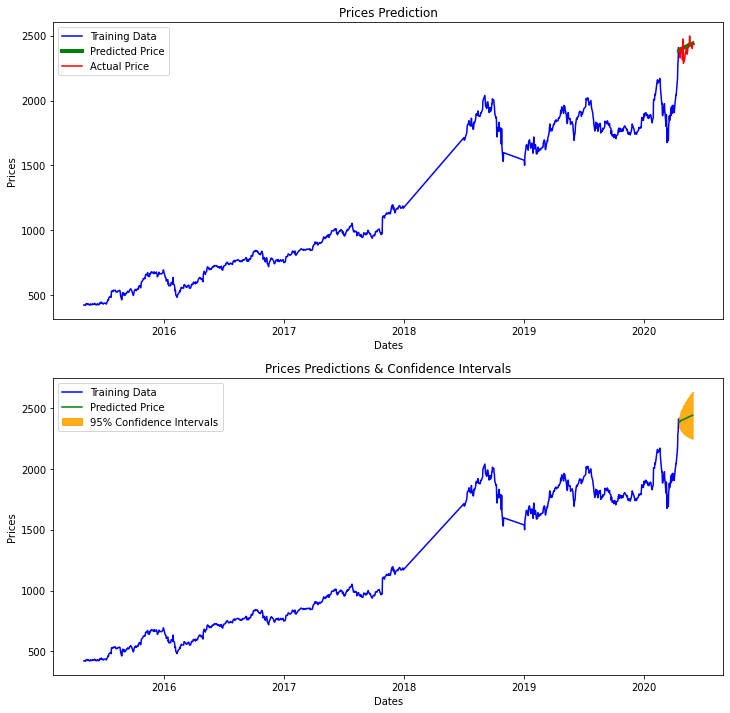

In [56]:
# Better forecast plots
plotForeCastBetter=symbolFolder+"/plot_ARIMA_forecast_better_"+symbol+".pdf"
fig, axes = pyplot.subplots(2, 1, figsize=(12, 12))

# --------------------- Actual vs. Predicted --------------------------
axes[0].plot(priceCloseTrain, color='blue', label='Training Data')
axes[0].plot(priceCloseTest.index, future_forecast, color='green', linewidth=4, label='Predicted Price')

axes[0].plot(priceCloseTest.index, priceCloseTest, color='red', label='Actual Price')
axes[0].set_title('Prices Prediction')
axes[0].set_xlabel('Dates')
axes[0].set_ylabel('Prices')
axes[0].legend()


# ------------------ Predicted with confidence intervals ----------------
axes[1].plot(priceCloseTrain, color='blue', label='Training Data')
axes[1].plot(priceCloseTest.index, future_forecast, color='green',
             label='Predicted Price')

axes[1].set_title('Prices Predictions & Confidence Intervals')
axes[1].set_xlabel('Dates')
axes[1].set_ylabel('Prices')

conf_int = np.asarray(conf_int)
axes[1].fill_between(priceCloseTest.index, conf_int[:, 0], conf_int[:, 1],
                     alpha=0.9, color='orange', label="95% Confidence Intervals")
axes[1].legend()
pyplot.savefig(plotForeCastBetter, bbox_inches='tight')


In [ ]:
###### PROBABILITY GRAPH FROM ARIMA MODEL

# Note to Rim and Quinn: ARIMA model computes a predicted mean mu at kdays and a 95% confidence interval
# To compute the probability graph (AKA density function in statistics),
# we calculate the Standard Error (SE) from the lower bound of the confidence interval.
# Once we have the mean mu and the SE, then we can plot the probability graph.

# Current price
priceCloseCurrent=priceCloseTrain.iloc[len(priceCloseTrain)-1]

# Extract predicted mean and confidence interval
mu=future_forecast.iloc[kdays-1,0]
lower=conf_int[kdays-1,0]
upper=conf_int[kdays-1,1]
print("mu="+str(round(mu,3)))

# Compute Standard Error (SE) from predicted confidence interval (reverse engineering here ;) )
se=(mu-lower)/norm.ppf(0.975)
print("SE="+str(round(se,3)))

# Probability graph
plotProbabilityGraph=symbolFolder+"/plot_ARIMA_probabilityGraph_"+symbol+"_"+str(kdays)+"days.pdf"
x = np.linspace(mu - 3*se, mu + 3*se, 100)
pyplot.plot(x, norm.pdf(x, mu, se))
pyplot.axvline(x=priceCloseCurrent,color='red',label='Current Price')
pyplot.axvline(x=lower,color='green',label='95% Pred Interval')
pyplot.axvline(x=upper,color='green')
pyplot.xlabel('Stock price ($)', fontsize=18)
pyplot.ylabel('Probability', fontsize=18)
pyplot.legend(loc='upper right')
pyplot.savefig(plotProbabilityGraph, bbox_inches='tight')
pyplot.show()